In [241]:
%pip install ISLP
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import Stepwise 
from ISLP.models import sklearn_selected
from ISLP.models import sklearn_selection_path

%pip install l0bnb
from l0bnb import fit_path

from sklearn.datasets import load_diabetes

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [242]:
# Cargar el dataset de Diabetes
diabetes = load_diabetes()

# Crear un DataFrame con los datos
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Agregar la columna de etiquetas (progresión de la diabetes)
df_diabetes['Progression'] = diabetes.target

# Mostrar las primeras filas
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [243]:
np.isnan(df_diabetes['Progression']).sum()

0

# Selección de subconjuntos
Aquí vamos a implementar los métodos que reducen el número de parámetros en un modelo restringuiendo el modelo a un subconjunto de los predictores. 
## Selección Paso a Paso hacia Adelante
Vamos a aplicar la Selección Paso a Paso hacia Adelante a los datos Diabetes. Deseamos predecir la progresion de la enfermedad un año después de ciertas mediciones básicas. 

Lo primero que vamos a hacer es elegir el mejor modelo usando la Selección Paso a Paso hacia Adelante basada en Cp de Mallows. Esta medida no esta construida como una métrica en sklearn, por tanto, debemos definirla nosotros mismos. Por defecto, sklearn intenta maximizar una puntuación, por lo tanto, nuestra función de evaluación calcula el estadístico Cp en forma negativa

In [244]:
def nCp(sigma2 , estimator , X, Y):
    #Negative Cp statistic
    n, d = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * d * sigma2) / n

Como necesitamos calcular el valor residual de la varianza 
$\sigma^{2}$, tenemos que calcular el mayor completo (contiene todos los predictores) por OLS y estimar $\sigma^{2}$ basado en su MSE.

In [245]:
design = MS(df_diabetes.columns.drop('Progression')).fit(df_diabetes)
Y = np.array(df_diabetes['Progression'])
X = design.transform(df_diabetes)
sigma2 = OLS(Y,X).fit().scale

In [246]:
model = OLS(Y, X).fit()  # Ajustar el modelo
model.summary()  # Obtener el resumen del modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Thu, 08 May 2025   Prob (F-statistic):           3.83e-62
Time:                        18:05:41   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    152.1335      2.576     59.061      0.000     147.071     157.196
age          -10.0099     59.749     -0.168      0.867    -127.446     107.426
sex         -239.8156     61.222     -3.917      0.000    -360.147    -119.484
bmi          519.8459     66.533      7.813      0.000     389.076     650.616
bp           324.3846     65.422      4.958      0.000     195.799     452.970
s1          -792.1756    416.680     -1.901      0.058   -1611.153      26.802
s2           476.7390    339.030      1.406      0.160    -189.620    1143.098
s3           101.0433    212.531      0.475      0.635    -316.684     518.770
s4           177.0632    161.476      1.097      0.273    -140.315     494.441
s5           751.2737    171.900      4.370      0.000     413.407    1089.140
s6            67.6267     65.984      1.025      0.306     -62.064     197.318
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.404
Skew:                           0.017   Prob(JB):                        0.496
Kurtosis:                       2.726   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
neg_Cp = partial(nCp , sigma2)

Ya podemos usar el neg_Cp() como una medida para la seleccion de modelos

In [248]:
estimator = LinearRegression().fit(X,Y)
neg_Cp(estimator, X, Y)

-3005.6669268139162

Stepwise() viene incluido en el paquete ISLP.models, el cual nos ayuda a realizar la Selección Paso a Paso. 
El método Stepwise.first_peak() realiza la Selección Paso a Paso mientras el modelo siga mejorando la métrica de evaluación. En el momento en que agregar otra variable no mejore la puntuación, el algoritmo se detiene

In [249]:
strategy = Stepwise.first_peak(design , direction='forward', max_terms=len(design.terms))

In [250]:
diabetes_MSE = sklearn_selected(OLS , strategy)
diabetes_MSE.fit(df_diabetes , Y)
diabetes_MSE.selected_state_

('age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'sex')

Si no se especifica un argumento de puntuación (scoring), la puntuación predeterminada será el MSE, y por lo tanto, se seleccionaran las 10 variables (todas menos la target). 

Usando neg_Cp() tenemos como resultado un modelo más pequeño, como es esperado, con solo 6 variables seleccionadas. 

In [251]:
diabetes_Cp = sklearn_selected(OLS , strategy ,scoring=neg_Cp)
diabetes_Cp.fit(df_diabetes , Y)
diabetes_Cp.selected_state_

('bmi', 'bp', 's1', 's2', 's5', 'sex')

Como alternativa al uso de Cp de Mallows, vamos a utilizar la validación cruzada para seleccionar el modelo con la Selección Paso a Paso hacia Adelante. Para esto, necesitamos un método que almacene la ruta completa de los modelos encontrados en la Selección Paso a Paso hacia Adelante y permita realizar predicciones para cada uno de ellos.
Esto lo podemos hacer con sklearn_selection_path() de ISLP.models. Además, la función cross_val_predict() from ISLP.models realiza las predicciones de la validación cruzada para cada uno de los modelos a lo largo de la ruta, que podemos utilizar para evaluar el MSE de la validación cruzada a lo largo de la ruta. 

El método Stepwise.fixed_steps() realiza la Selección Paso a Paso con un número de pasos fijos. 

Si bien existen varias opciones de parámetros para sklearn_selection_path(), aquí usamos los valores predeterminados, que seleccionan el modelo en cada paso según la mayor reducción en RSS.

In [252]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

In [253]:
full_path.fit(df_diabetes, Y)
Yhat_in = full_path.predict(df_diabetes)
Yhat_in.shape

(442, 11)

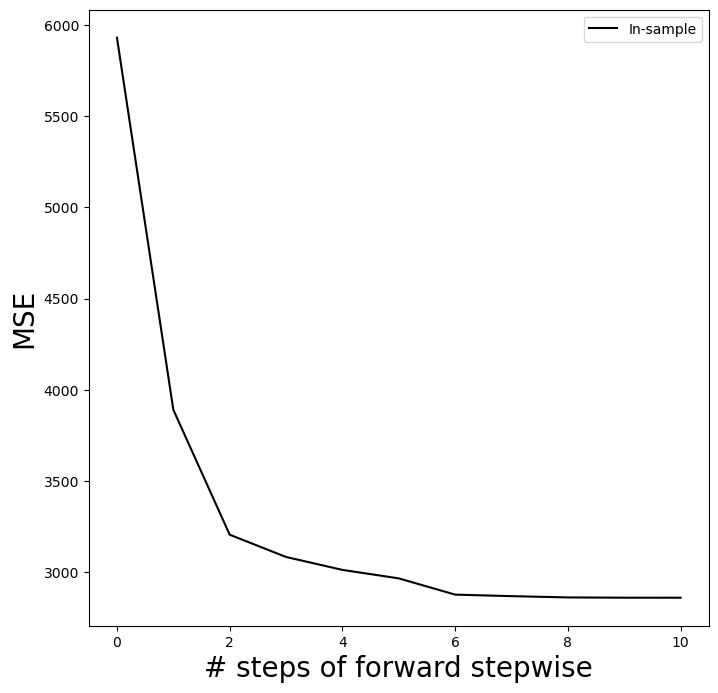

In [254]:
mse_fig , ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse ,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
                fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
                fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()

Como era de esperar, el MSE dentro de la muestra mejora con cada paso, lo que indica que debemor usar el enfoque de validación o validación cruzada para seleccionar el número de pasos. 

Ahora estamos listos para usar la validación cruzada para estimar el error de prueba a lo largo de la ruta del modelo. Debemos usar solo las observaciones de entrenamiento para realizar todos los aspectos del ajuste del modelo, incluida la selección de variables. Por lo tanto, la determinación de qué modelo de un tamaño dado es el mejor debe realizarse utilizando solo las observaciones de entrenamiento en cada pliegue de entrenamiento. Este punto es sutil pero importante. Si se utiliza el conjunto de datos completo para seleccionar el mejor subconjunto en cada paso, los errores del conjunto de validación y los errores de validación cruzada que obtengamos no serán estimaciones precisas del error de prueba.

In [255]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path , df_diabetes , Y, cv=kfold)
Yhat_cv.shape

(442, 11)

Debemos conocer los índices de prueba para cada división de validación cruzada. Esto se puede obtener utilizando el método split() de kfold. Dado que corregimos el estado aleatorio anterior, al dividir cualquier matriz con el mismo número de filas que Y, recuperamos los mismos índices de entrenamiento y prueba

In [256]:
cv_mse = []
for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx ,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(11, 5)

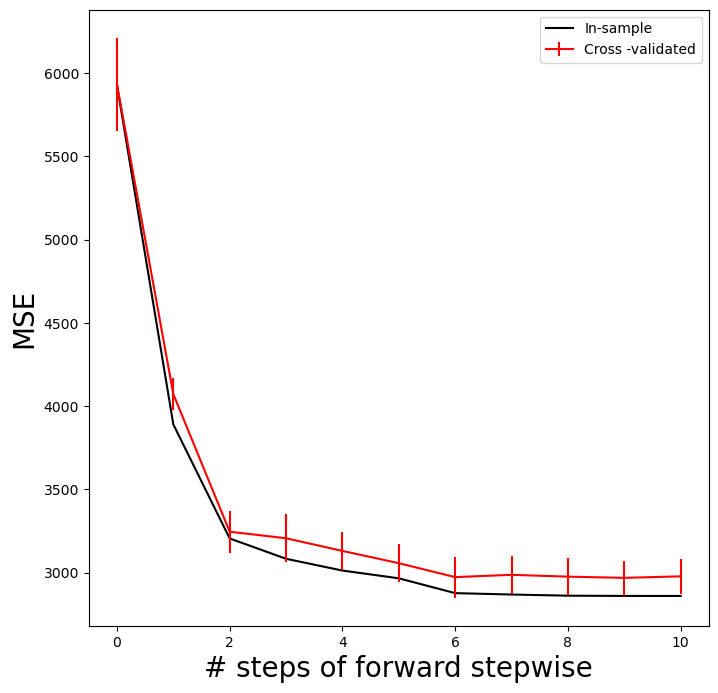

In [257]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1), cv_mse.std(1) / np.sqrt(K), label='Cross -validated', c='r') # color red
ax.legend()
mse_fig

Ahora, vamos a repetir lo anterior pero utilizando el enfoque de validación, donde escogemos una división aleatoria de los datos en una prueba y un entrenamiento. Elegimos un tamaño de prueba del 20%, similar al tamaño de cada conjunto de prueba en la validación cruzada de 5 pasos. 

In [258]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx , test_idx in validation.split(Y):
    full_path.fit(df_diabetes.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(df_diabetes.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx ,None])**2
    validation_mse = errors.mean(0)

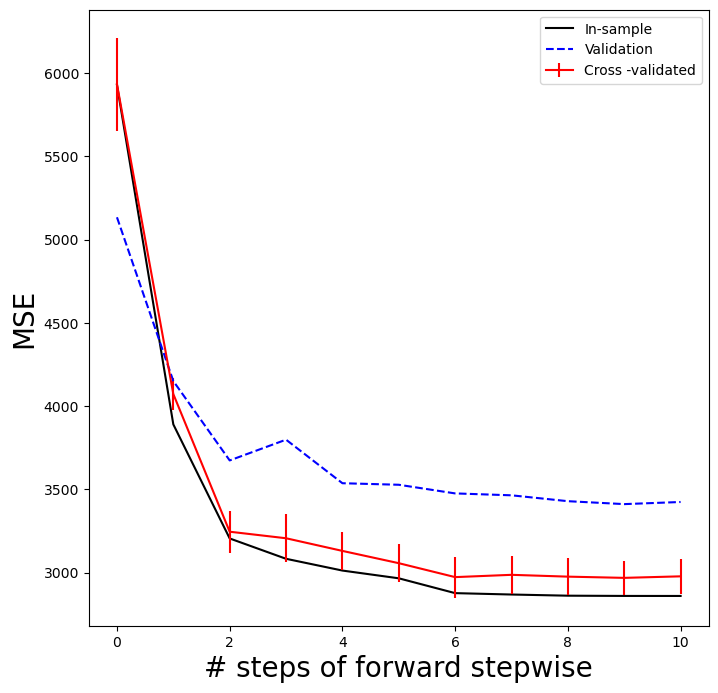

In [259]:
ax.plot(np.arange(n_steps), validation_mse ,'b--', label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
mse_fig

## Selección del mejor subconjunto

Utilizaremos un paquete llamado l0bnb para realizar la selección del mejor subconjunto. En lugar de restringir el subconjunto a un tamaño determinado, este paquete genera una ruta de soluciones utilizando el tamaño del subconjunto como penalización en lugar de como restricción.
Aunque la distinción es sutil, la diferencia surge al realizar la validación cruzada.

In [260]:
D = design.fit_transform(df_diabetes)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

Excluimos la primera columna correspondiente al intercept, ya que l0bnb ajustara el intercept por separado. Podemos encontrar la ruta usando fit_path()

In [ ]:
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  5
Iteration: 5. Number of non-zeros:  5
Iteration: 6. Number of non-zeros:  5
Iteration: 7. Number of non-zeros:  5
Iteration: 8. Number of non-zeros:  5
Iteration: 9. Number of non-zeros:  5
Iteration: 10. Number of non-zeros:  5
Iteration: 11. Number of non-zeros:  8
Iteration: 12. Number of non-zeros:  10


In [262]:
path[3]

{'B': array([   0.        , -227.62042416,  517.51517279,  322.88217628,
           0.        ,    0.        , -285.13485375,    0.        ,
         469.28684194,    0.        ]),
 'B0': 152.13348416289602,
 'lambda_0': 0.008044294245460364,
 'M': 0.4930779003689426,
 'Time_exceeded': False}

En la iteraccion 10 hay 5 coeficientes distios de 0, correspondientes al valor 0.008044294245460364 del parámetro de penalizacion lambda_0. 

# Métodos de penalización

In [263]:
Xs = X - X.mean(0)[None ,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None ,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                    Y,
                                    l1_ratio=0.,
                                    alphas=lambdas)[1]
soln_array.shape

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6425459.02773542, tolerance: 1285.0921
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\line

(10, 100)

In [264]:
soln_path = pd.DataFrame(soln_array.T,
                            columns=D.columns ,
                            index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
negative log(lambda),,,,,,,,,,
-14.076801,0.000011,0.000003,0.000035,0.000026,0.000013,0.000010,-0.000023,0.000026,0.000034,0.000023
-13.844216,0.000014,0.000003,0.000044,0.000033,0.000016,0.000013,-0.000030,0.000032,0.000042,0.000029
-13.611632,0.000018,0.000004,0.000055,0.000042,0.000020,0.000016,-0.000037,0.000041,0.000053,0.000036
-13.379048,0.000022,0.000005,0.000070,0.000053,0.000025,0.000021,-0.000047,0.000051,0.000067,0.000046
-13.146463,0.000028,0.000006,0.000088,0.000066,0.000032,0.000026,-0.000059,0.000065,0.000085,0.000058
...,...,...,...,...,...,...,...,...,...,...
8.018713,-0.468470,-11.394966,24.735842,15.420177,-36.335105,21.609049,4.212262,8.260525,35.224237,3.224803
8.251297,-0.470020,-11.397393,24.734009,15.422055,-36.605934,21.823944,4.331816,8.292996,35.327038,3.223146
8.483882,-0.471262,-11.399332,24.732522,15.423556,-36.823558,21.996624,4.427899,8.319108,35.409623,3.221823


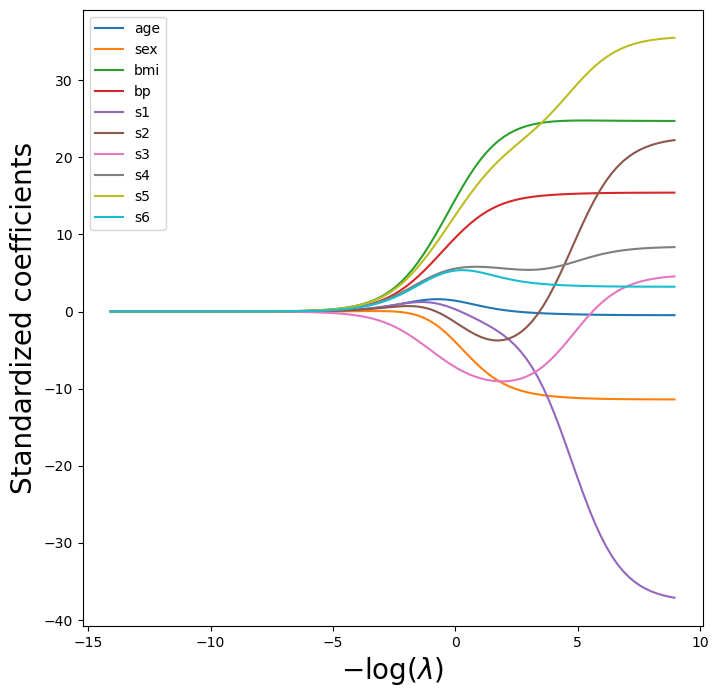

In [265]:
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [266]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(149.30794870124944,
 age    0.093774
 sex    0.019786
 bmi    0.296989
 bp     0.223029
 s1     0.104987
 s2     0.085414
 s3    -0.198928
 s4     0.215720
 s5     0.285710
 s6     0.192154
 Name: -5.006010942921992, dtype: float64)

In [267]:
np.linalg.norm(beta_hat)

0.608365317788955

In [268]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(1.4252167200012205, 21.29756329870925)

In [269]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True , with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.987e+05, tolerance: 2.621e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=1.4252167200012205, l1_ratio=0))])

In [270]:
np.linalg.norm(ridge.coef_)

21.297563298709235

In [271]:
validation = skm.ShuffleSplit(n_splits=1,
                                test_size=0.5,
                                random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge ,
                                X,
                                Y,
                                scoring='neg_mean_squared_error',
                                cv=validation)
-results['test_score']

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.575e+05, tolerance: 1.411e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([3880.82825378])

In [272]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge ,
                                X,
                                Y,
                                scoring='neg_mean_squared_error',
                                cv=validation)
-results['test_score']

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.056e+05, tolerance: 1.411e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([5479.57246985])

In [273]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe ,
                        param_grid ,
                        cv=validation ,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.056e+05, tolerance: 1.411e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.056e+05, tolerance: 1.411e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the so

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.35303706392790785, l1_ratio=0))])

In [274]:
grid = skm.GridSearchCV(pipe ,
                        param_grid ,
                        cv=kfold ,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+06, tolerance: 2.164e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+06, tolerance: 2.144e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the so

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005365849461571904, l1_ratio=0))])

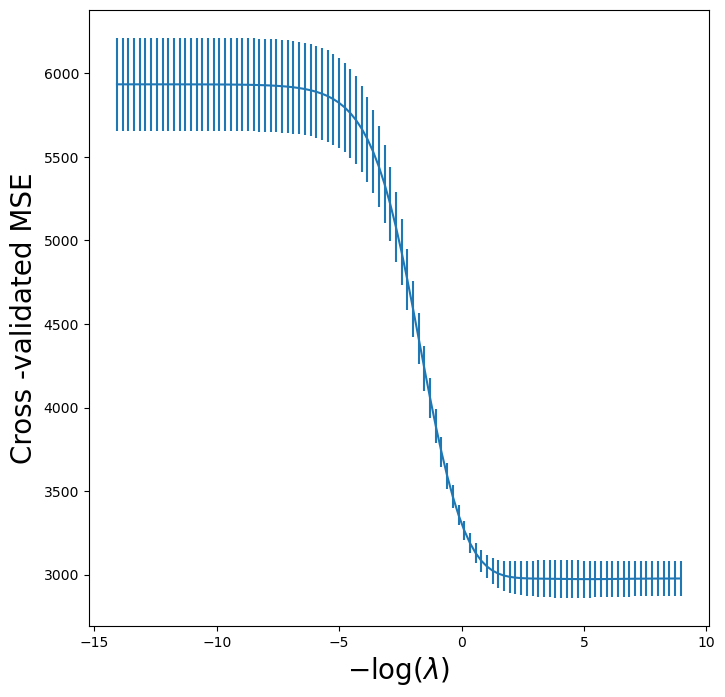

In [275]:
ridge_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20);

In [276]:
grid_r2 = skm.GridSearchCV(pipe ,
                            param_grid ,
                            cv=kfold)
grid_r2.fit(X, Y)

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.082e+06, tolerance: 2.164e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+06, tolerance: 2.144e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the so

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([1.29860439e+06, 1.02912177e+06, 8.15561407e+05, 6.46318467e+05,
       5.12196332e+05, 4.05906834e+05, 3.21674224e+05, 2.54921322e+05,
       2.02020788e+05, 1.60098019...
       2.73343777e-02, 2.16620269e-02, 1.71667858e-02, 1.36043842e-02,
       1.07812418e-02, 8.54394977e-03, 6.77093408e-03, 5.36584946e-03,
       4.25234393e-03, 3.36990985e-03, 2.67059592e-03, 2.11640160e-03,
       1.67721207e-03, 1.32916188e-03, 1.05333806e-03, 8.34752400e-04,
       6.61527001e-04, 5.24248835e-04, 4.15458236e-04, 3.29243547e-04,
       2.60919881e-04, 2.06774543e-04, 1.63865289e-04, 1.29860439e-04])})

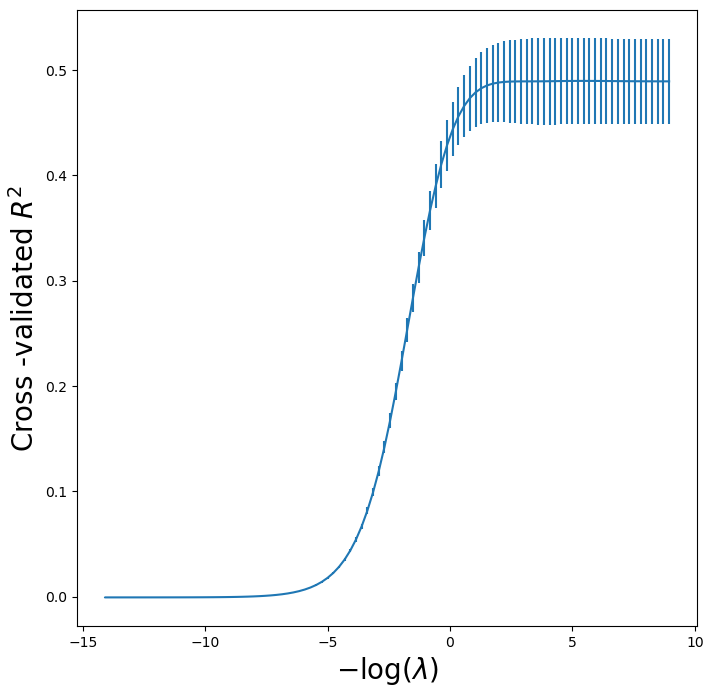

In [277]:
r2_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated $R^2$', fontsize=20);

In [278]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
                            l1_ratio=0,
                            cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1082066.7958232618, tolerance: 216.41362662889517
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\s

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([1.29860439e+06, 1.02912177e+06, 8.15561407e+05, 6.46318467e+05,
       5.12196332e+05, 4.05906834e+05, 3.21674224e+05, 2.54921322e+05,
       2.02020788e+05, 1.60098019e+05, 1.26874942e+05, 1.00546222e+05,
       7.96811615e+04, 6.31459578e+04, 5.00420917e+04, 3.96575018e+04,
       3.14278920e+04, 2.49060669e+04,...
       1.07812418e-02, 8.54394977e-03, 6.77093408e-03, 5.36584946e-03,
       4.25234393e-03, 3.36990985e-03, 2.67059592e-03, 2.11640160e-03,
       1.67721207e-03, 1.32916188e-03, 1.05333806e-03, 8.34752400e-04,
       6.61527001e-04, 5.24248835e-04, 4.15458236e-04, 3.29243547e-04,
       2.60919881e-04, 2.06774543e-04, 1.63865289e-04, 1.29860439e-04]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

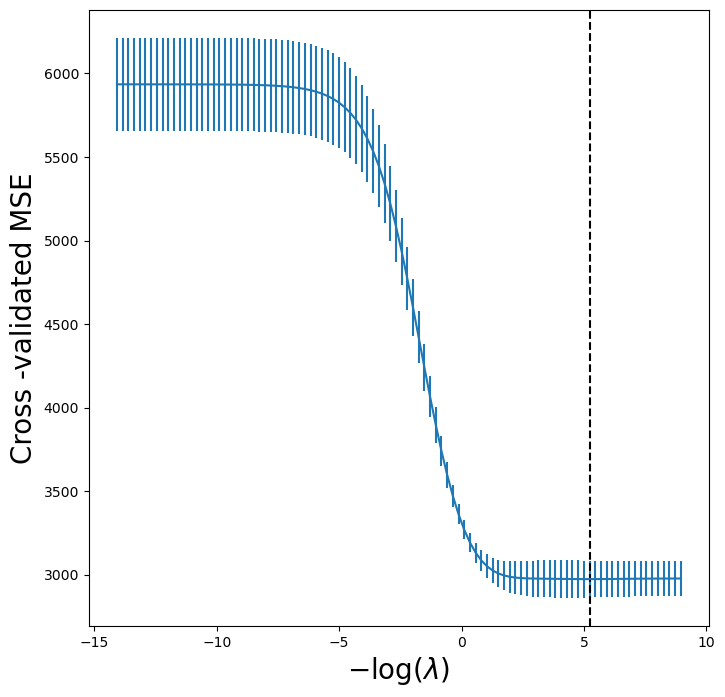

In [279]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20);

In [280]:
np.min(tuned_ridge.mse_path_.mean(1))

2973.6865194511915

In [281]:
tuned_ridge.coef_

array([ -0.38809027, -11.25413002,  24.78598793,  15.31490029,
       -23.68450442,  11.57550082,  -1.33518922,   6.79121533,
        30.37457438,   3.31951815])

In [282]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                                test_size=0.25,
                                random_state=1)
inner_cv = skm.KFold(n_splits=5,
                    shuffle=True ,
                    random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
                            l1_ratio=0,
                            cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                        ('ridge', ridgeCV)]);

In [283]:
results = skm.cross_validate(pipeCV ,
                            X,
                            Y,
                            cv=outer_valid ,
                            scoring='neg_mean_squared_error')
-results['test_score']

c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 822117.3369570195, tolerance: 164.42366666666666
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\sk

array([2935.0941225])

In [284]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                            l1_ratio=1,
                            cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                        ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.8462165106924138

In [285]:
lambdas , soln_array = skl.Lasso.path(Xs,
                                        Y,
                                        l1_ratio=1,
                                        n_alphas =100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                        columns=D.columns ,
                        index=-np.log(lambdas))

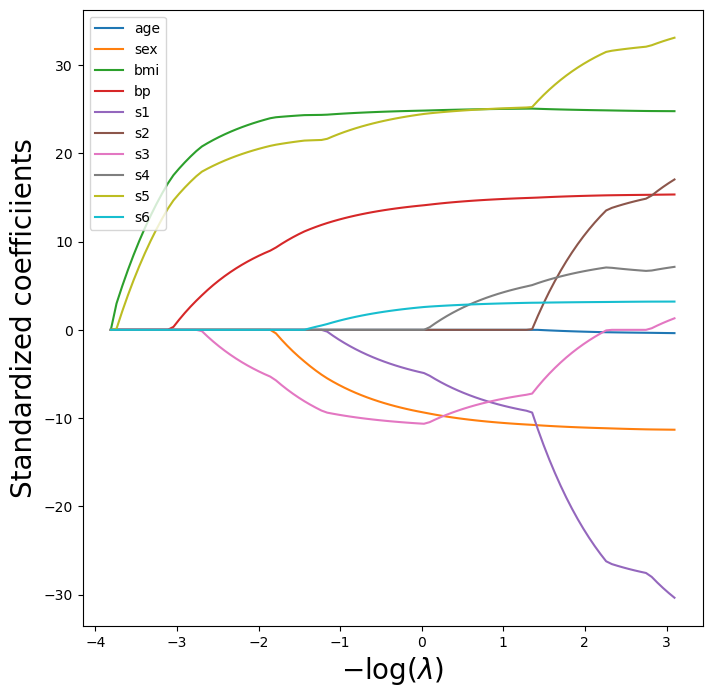

In [286]:
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [287]:
np.min(tuned_lasso.mse_path_.mean(1))

2971.748390412232

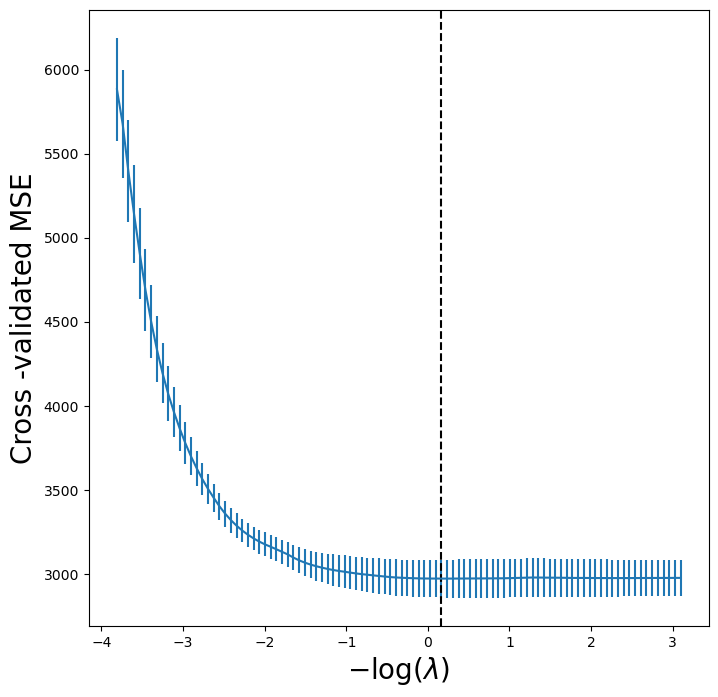

In [288]:
lassoCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
                    tuned_lasso.mse_path_.mean(1),
                    yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20);

In [289]:
tuned_lasso.coef_

array([ -0.        ,  -9.61074957,  24.87351347,  14.25747299,
        -5.58452937,  -0.        , -10.1562662 ,   0.74479813,
        24.59088989,   2.675016  ])

In [290]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([ 448.19478633, -256.74894229])

In [291]:
pipe = Pipeline([('scaler', scaler),
                ('pca', pca),
                ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([ 21.31845198, -12.2123018 ])

In [292]:
param_grid = {'pca__n_components': range(1, 11)}
grid = skm.GridSearchCV(pipe ,
                        param_grid ,
                        cv=kfold ,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 11)},
             scoring='neg_mean_squared_error')

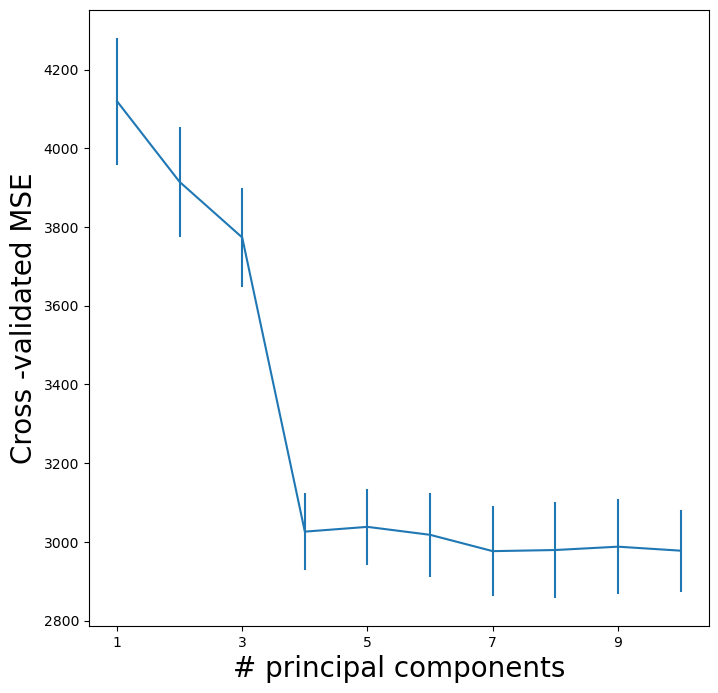

In [293]:
pcr_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp ,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2])

In [294]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg ,
                             Xn,
                            Y,
                            cv=kfold ,
                            scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

5934.577616407384

In [295]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.40242108, 0.14923197])

In [296]:
pls = PLSRegression(n_components=2, 
                    scale=True)
pls.fit(X, Y)

PLSRegression()

In [297]:
param_grid = {'n_components':range(1, 11)}
grid = skm.GridSearchCV(pls ,
param_grid ,
cv=kfold ,
scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 11)},
             scoring='neg_mean_squared_error')

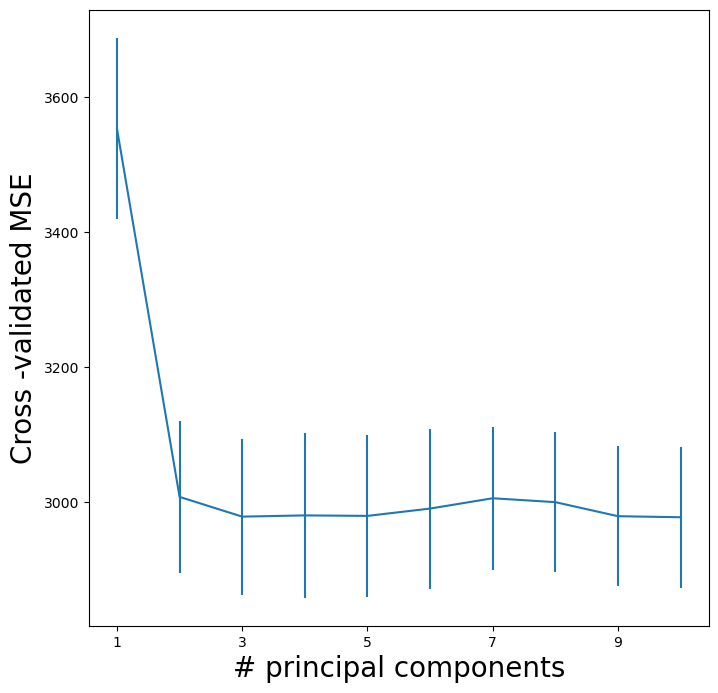

In [298]:
pls_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp ,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2]);